## Interpret similarity between shoes
Zappos50K dataset: http://vision.cs.utexas.edu/projects/finegrained/utzap50k/

In [11]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range, str
from glob import glob
import numpy as np
np.random.seed(28)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from PIL import Image
from sklearn.metrics import pairwise_distances
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
import innvestigate
import innvestigate.utils

from simec import LastLayerReg

%matplotlib inline
%load_ext autoreload
%autoreload 2
# set this to True if you want to save the figures
savefigs = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# move images into a single folder and rename files to match csv meta data
# import os
# import shutil
# for img in glob("data/zappos50k/ut-zap50k-images-square/*/*/*/*.jpg"):
#     shutil.move(img, os.path.join("data/zappos50k/images/", img.split("/")[-1].replace(".", "-", 1)))

In [2]:
# read in the meta data
df = pd.read_csv("data/zappos50k/ut-zap50k-data/meta-data.csv")
# transform ids to actual file paths
df["CID"] =  df["CID"] + ".jpg"

### Predict Shoe Types with CNN & Interpret

In [ ]:
# load images with classes based on dataframe
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = image_gen.flow_from_dataframe(df, "data/zappos50k/images", "CID", "Category", 
                                                target_size=(136, 136), seed=12)

In [ ]:
# build cnn model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(136, 136, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
# train with data from generator
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=1)

In [ ]:
# get batch with images and lables
x, y = train_generator.next()
y = np.argmax(y, axis=1)
pred = np.argmax(model.predict(x), axis=1)
class_map = {i: c for (c, i) in train_generator.class_indices.items()}

# Strip softmax layer off model
anal_model = innvestigate.utils.model_wo_softmax(model)
# Create analyzer
analyzer = innvestigate.create_analyzer('lrp.sequential_preset_a_flat', anal_model)
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)
# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))

# Plot all images
for i in range(x.shape[0]):
    # get alpha values based on heatmap
    alphas = np.abs(a[i])
    alphas /= alphas.max()
    # convert heatmap to colors
    colors = plt.cm.seismic(Normalize(-1, 1, clip=True)(a[i]/np.max(np.abs(a[i]))))
    # set alpha channel
    colors[..., -1] = alphas
    # convert x to gray scale
    x_gray = np.array(Image.fromarray(np.uint8(255*x[i])).convert("L").convert("RGBA"))/255.
    # set alpha channel
    x_gray[..., -1] = 0.75*(1-alphas)
    # plot stuff
    plt.figure()
    plt.imshow(x_gray, cmap="gray")
    plt.imshow(colors)
    plt.title("true: %s, predicted: %s" % (class_map[y[i]], class_map[pred[i]]))
    plt.axis("off")

## Learn & Interpret Similarities

We're considering similarities with respect to the opening mechanism (e.g. laces, zipper, etc.) as well as the heel height.

In [3]:
# filter shoes and only keep those with a non-NaN heel height / closure
df = df[['CID', 'Category', 'HeelHeight', 'Closure']]
df.dropna(inplace=True)  # ca 30k left
df.reset_index(inplace=True, drop=True)
# explicitly store the index, which we'll need later for the data generator
df["index"] = df.index
# map heel heights to numeric values
heel_heights = ['Flat', 'Under 1in', '1in - 1 3/4in', '2in - 2 3/4in', 
                '3in - 3 3/4in', '4in - 4 3/4in', '5in & over']
heel_map = {h: i for i, h in enumerate(heel_heights)}
df["HeelHeightNum"] = df["HeelHeight"].map(heel_map)
# randomly select 1k target images
n_targets = 1000
target_df = df.sample(n_targets, random_state=5)

In [4]:
# get image generator
# in terms of y we only want the index, which we can then use to index the rows of the similarity matrix
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = image_gen.flow_from_dataframe(df, "data/zappos50k/images", "CID", "index", 
                                                class_mode="other", target_size=(136, 136), seed=23)
# same for target images
target_generator = image_gen.flow_from_dataframe(target_df, "data/zappos50k/images", "CID", "index", 
                                                 class_mode="other", target_size=(136, 136), shuffle=False)

Found 29276 images.
Found 1000 images.


In [5]:
# save a batches for later analysis
x, y = train_generator.next()
x_t, y_t = target_generator.next()

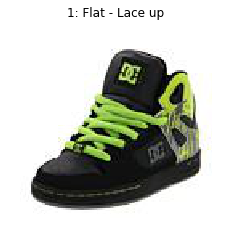

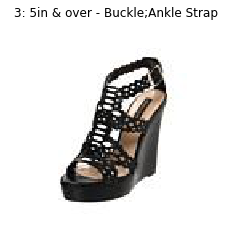

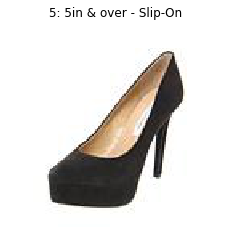

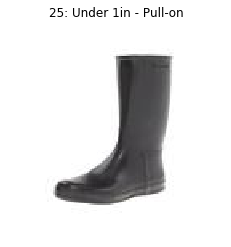

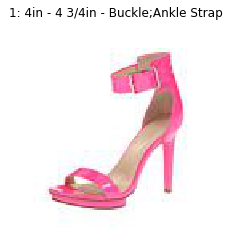

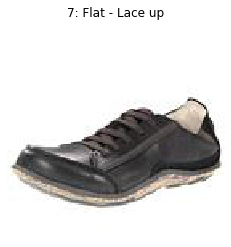

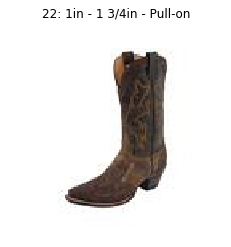

In [6]:
# inspect images to select some input and target images
selected_inputs = [1, 3, 5, 25] #range(x.shape[0])
selected_targets = [1, 7, 22] #range(x_t.shape[0])
for t in selected_inputs:
    plt.figure()
    plt.imshow(x[t])
    plt.axis("off")
    plt.title("%i: %s - %s" % (t, df.loc[y[t], "HeelHeight"], df.loc[y[t], "Closure"]))
for t in selected_targets:
    plt.figure()
    plt.imshow(x_t[t])
    plt.axis("off")
    plt.title("%i: %s - %s" % (t, target_df.loc[y_t[t], "HeelHeight"], target_df.loc[y_t[t], "Closure"]))

In [7]:
class PrintLossLine(keras.callbacks.Callback):
    def __init__(self, n_batches=1):
        super(PrintLossLine, self).__init__()
        self.losses = []
        self.n_batches = n_batches
        self.i = 0

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.i += 1
        print("%5i / %i - Loss: %.6f" % (self.i, self.n_batches, logs.get('loss')), end="\r")
        

def build_train_simec(train_generator, S, S_ll):
    # build CNN SimEc model (manually)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(136, 136, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    # SimEc last layer with s_ll_reg
    model.add(Dense(S.shape[1], use_bias=False, 
                    kernel_regularizer=LastLayerReg(s_ll_reg=100., S_ll=S_ll)))

    model.compile(keras.optimizers.Adam(), loss="mean_squared_error")

    # train simec - batchwise for two epochs
    n_batches = 2*(train_generator.n//train_generator.batch_size)
    printer = PrintLossLine(n_batches)
    for i, (x_batch, y_batch) in enumerate(train_generator):
        model.fit(x_batch, S[y_batch], batch_size=train_generator.batch_size, 
                  epochs=1, shuffle=False, verbose=0, callbacks=[printer])
        if i >= n_batches:
            break
    
    plt.figure()
    plt.plot(printer.losses)
    plt.xlabel("number of batches")
    plt.ylabel("loss (MSE)")
    plt.title("learning curve")
    return model

### Interpret w.r.t. given target image - HeelHeight

W0212 20:57:06.704358 140241570400064 module_wrapper.py:139] From /home/franzi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0212 20:57:06.706877 140241570400064 module_wrapper.py:139] From /home/franzi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0212 20:57:06.709423 140241570400064 module_wrapper.py:139] From /home/franzi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0212 20:57:06.729643 140241570400064 module_wrapper.py:139] From /home/franzi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0212 20:57:06.732415 14024

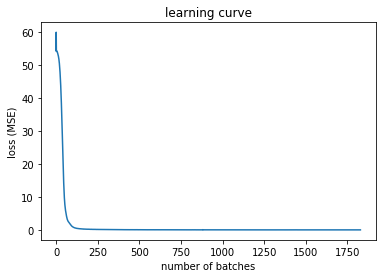

In [8]:
# compute similarity matrix based on abs difference between heel heights
S = pairwise_distances(df[["HeelHeightNum"]], target_df[["HeelHeightNum"]])
# normalize and transform to similarity
S /= S.max()
S = 1. - S
S_ll = S[target_df.index]
# train model
model = build_train_simec(train_generator, S, S_ll)

In [9]:
# analyze predictions w.r.t. a certain target image ("why is A similar to B?")
model.layers[-1].kernel_regularizer = None  # custom LastLayerReg is unknown
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a_flat",  model, neuron_selection_mode="index")

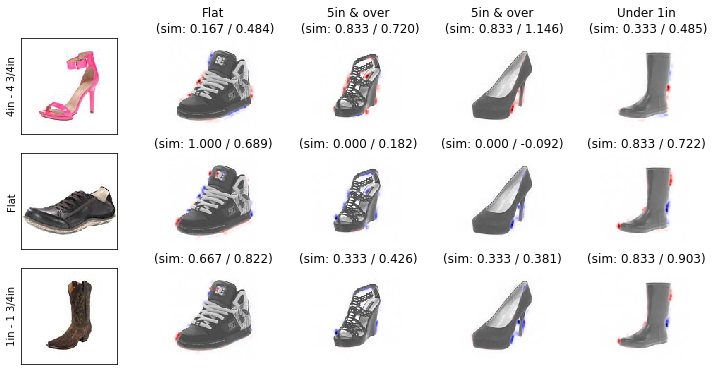

In [12]:
# similarity of images in the batch to target image t
pred = model.predict(x)
plt.figure(figsize=(2.5*(1+len(selected_inputs)), 2*len(selected_targets)))
s = 0
for t in selected_targets:
    # plot target image first
    s += 1
    plt.subplot(len(selected_targets), len(selected_inputs) + 1, s)
    plt.imshow(x_t[t])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel(target_df.loc[y_t[t], "HeelHeight"])
    #plt.title("Target Image")
    
    a = analyzer.analyze(x, t)

    # Aggregate along color channels and normalize to [-1, 1]
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))
    
    # Plot all images
    for i in selected_inputs:
        s += 1
        plt.subplot(len(selected_targets), len(selected_inputs) + 1, s)
        # get alpha values based on heatmap
        alphas = np.abs(a[i])
        alphas /= alphas.max()
        # convert heatmap to colors
        colors = plt.cm.seismic(Normalize(-1, 1, clip=True)(a[i]/np.max(np.abs(a[i]))))
        # set alpha channel
        colors[..., -1] = np.minimum(1.5*alphas, 1.)
        # convert x to gray scale
        x_gray = np.array(Image.fromarray(np.uint8(255*x[i])).convert("L").convert("RGBA"))/255.
        # set alpha channel
        x_gray[..., -1] = 0.75*(1-alphas)
        plt.imshow(x_gray, cmap="gray")
        plt.imshow(colors)
        if t == selected_targets[0]:
            plt.title("%s\n (sim: %.3f / %.3f)" % (df.loc[y[i], "HeelHeight"], S[y[i], t], pred[i, t]))
        else:
            plt.title("(sim: %.3f / %.3f)" % (S[y[i], t], pred[i, t]))
        plt.axis("off")
if savefigs:
    plt.savefig("zappos_target_heel.png", dpi=300)

### Interpred based on two embeddings

In [13]:
# construct a new input with our selected images
x_new = np.concatenate((x_t[selected_targets], x[selected_inputs]))
y_new = np.concatenate((y_t[selected_targets], y[selected_inputs]))
# compute embeddings for target images
model_embed = Sequential(model.layers[:-1])
x_embed = model_embed.predict(x_new) # shape (x_new.shape[0], 512)
# get current weights of the simec last layer (no bias)
w = model.layers[-1].get_weights()   # shape (512, 1000)
# replace first few columns with transpose of embeddings
w[0][:, :x_embed.shape[0]] = x_embed.T
model.layers[-1].set_weights(w)
# construct analyzer from changed model
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a_flat",  model, neuron_selection_mode="index")

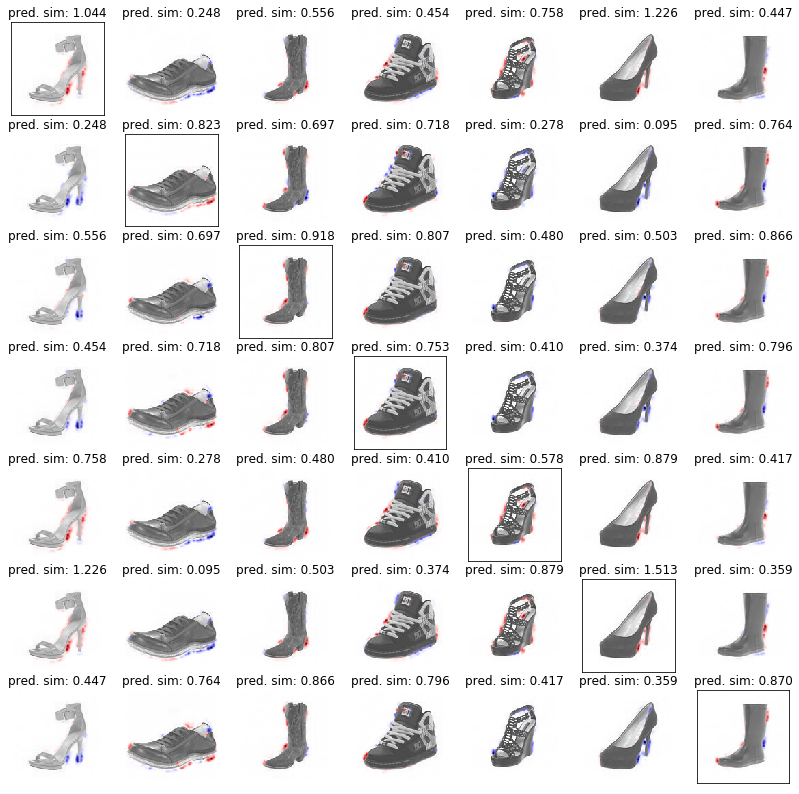

In [15]:
pred = model.predict(x_new)
plt.figure(figsize=(2*x_new.shape[0], 2*x_new.shape[0]))
s = 0
for t in range(x_new.shape[0]):
    a = analyzer.analyze(x_new, t)

    # Aggregate along color channels and normalize to [-1, 1]
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))

    # Plot all images
    for i in range(x_new.shape[0]):
        s += 1
        plt.subplot(x_new.shape[0], x_new.shape[0], s)
        # get alpha values based on heatmap
        alphas = np.abs(a[i])
        alphas /= alphas.max()
        # convert heatmap to colors
        colors = plt.cm.seismic(Normalize(-1, 1, clip=True)(a[i]/np.max(np.abs(a[i]))))
        # set alpha channel
        colors[..., -1] = np.minimum(1.5*alphas, 1.)
        # convert x to gray scale
        x_gray = np.array(Image.fromarray(np.uint8(255*x_new[i])).convert("L").convert("RGBA"))/255.
        # set alpha channel
        x_gray[..., -1] = 0.75*(1-alphas)
        plt.imshow(x_gray, cmap="gray")
        plt.imshow(colors)
        plt.title("pred. sim: %.3f" % pred[i, t])
        if t == i:           
            plt.xticks([], [])
            plt.yticks([], [])
        else:
            plt.axis("off")
if savefigs:
    plt.savefig("zappos_embed_heel.png", dpi=300)
# similarity between two images: position of image and transpose

### Interpretation with similarity based on closure

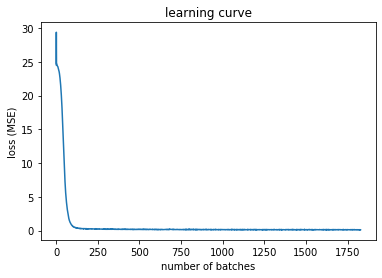

In [16]:
# compute similarity matrix based on sum(closure in common)/min(closure1, closure2)
# aka simpson similarity coefficient
def closure_sim(x, y):
    x, y = set(x.split(";")), set(y.split(";"))
    return len(x & y) / min(len(x), len(y))

# unfortunately, sklearn doesn't work with strings...
# S = pairwise_distances(df[["Closure"]][:10], target_df[["Closure"]], metric=closure_sim)
S = np.array([[closure_sim(df.loc[i, "Closure"], target_df.loc[j, "Closure"])
                           for j in target_df.index] for i in df.index])
S_ll = S[target_df.index]
# train model
model = build_train_simec(train_generator, S, S_ll)

In [17]:
# analyze predictions w.r.t. a certain target image ("why is A similar to B?")
model.layers[-1].kernel_regularizer = None  # custom LastLayerReg is unknown
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a_flat",  model, neuron_selection_mode="index")

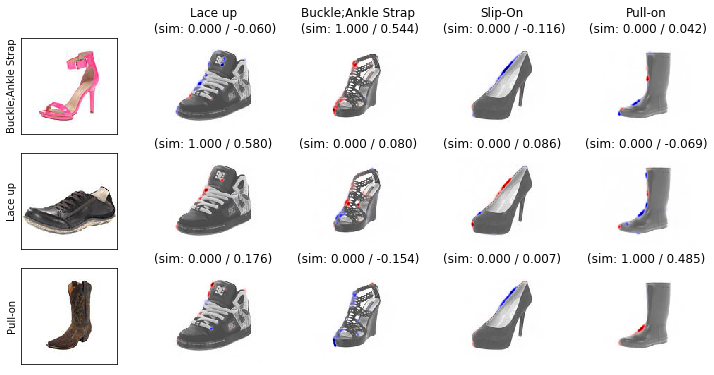

In [19]:
# similarity of images in the batch to target image t
pred = model.predict(x)
plt.figure(figsize=(2.5*(1+len(selected_inputs)), 2*len(selected_targets)))
s = 0
for t in selected_targets:
    # plot target image first
    s += 1
    plt.subplot(len(selected_targets), len(selected_inputs) + 1, s)
    plt.imshow(x_t[t])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel(target_df.loc[y_t[t], "Closure"])
    #plt.title("Target Image")
    
    a = analyzer.analyze(x, t)

    # Aggregate along color channels and normalize to [-1, 1]
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))

    # Plot all images
    for i in selected_inputs:
        s += 1
        plt.subplot(len(selected_targets), len(selected_inputs) + 1, s)
        # get alpha values based on heatmap
        alphas = np.abs(a[i])
        alphas /= alphas.max()
        # convert heatmap to colors
        colors = plt.cm.seismic(Normalize(-1, 1, clip=True)(a[i]/np.max(np.abs(a[i]))))
        # set alpha channel
        colors[..., -1] = np.minimum(1.5*alphas, 1.)
        # convert x to gray scale
        x_gray = np.array(Image.fromarray(np.uint8(255*x[i])).convert("L").convert("RGBA"))/255.
        # set alpha channel
        x_gray[..., -1] = 0.75*(1-alphas)
        plt.imshow(x_gray, cmap="gray")
        plt.imshow(colors)
        if t == selected_targets[0]:
            plt.title("%s\n (sim: %.3f / %.3f)" % (df.loc[y[i], "Closure"], S[y[i], t], pred[i, t]))
        else:
            plt.title("(sim: %.3f / %.3f)" % (S[y[i], t], pred[i, t]))
        plt.axis("off")
if savefigs:
    plt.savefig("zappos_target_close.png", dpi=300)